# Sistema de Reconhecimento Facial

Criado por: **Bruno Ferro**

Abaixo segue código completo e pronto para rodar no Colab que implementa o projeto do Módulo 6: detecção de faces (MTCNN) + extração de embeddings (InceptionResnetV1 pré-treinado / FaceNet) + treinamento de classificador (SVM) e inferência em imagens (várias faces simultâneas). O código assume um dataset em formato padrão dataset/<label>/<img>.jpg. Incluí comentários técnicos e passos mínimos de execução (montar Drive, estruturar dataset, treinar, testar).

Instruções de uso (resumidas)

1. Monte o Google Drive quando solicitado e coloque seu dataset em `drive/MyDrive/dataset_mod6/` (cada subpasta = uma pessoa).
2. Execute a célula de treinamento; ao final será gerado `svm_classifier.joblib` e `label_encoder.joblib`.
3. Use a célula de inferência para detectar/reconhecer múltiplas faces em imagens.








In [1]:
# Colab: sistema de detecção+reconhecimento facial (MTCNN + FaceNet embeddings + SVM)
# Requer: facenet-pytorch, scikit-learn, joblib, opencv-python
# Execute tudo em runtime com GPU (opcional, acelera embeddings)

# 1) Instalação

In [2]:

!pip install -q facenet-pytorch==2.5.2 joblib opencv-python scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.3 MB/s eta 0:00:00


# 2) Imports

In [3]:

import os
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib
import cv2
from glob import glob
from tqdm import tqdm

import kagglehub

# Download latest version of dataset

In [21]:
# path = kagglehub.dataset_download("ashfakyeafi/cat-dog-images-for-classification")
# path = kagglehub.dataset_download("tongpython/cat-and-dog")
# path = kagglehub.dataset_download("d4rklucif3r/cat-and-dogs")
# path = kagglehub.dataset_download("anthonytherrien/dog-vs-cat")
path = kagglehub.dataset_download("rishabhkmr/the-big-bang-theory-actors")

print("Path to dataset files:", path)

100%|██████████| 293M/293M [00:03<00:00, 87.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rishabhkmr/the-big-bang-theory-actors/versions/6


# 3) Configurações

In [23]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DATASET_DIR = '/content/drive/MyDrive/dataset_mod6'  # ajuste para seu caminho no Drive
DATASET_DIR = path
# DATASET_DIR = path + '/animals'                        # /kaggle/input/dog-vs-cat/animals
# DATASET_DIR = path + '/Cleaned Dataset'
BATCH_SIZE = 32
EMBEDDING_MODEL_NAME = 'vggface2'  # InceptionResnetV1 pretreinado em VGGFace2
CLASSIFIER_OUT = '/content/svm_classifier.joblib'
LABEL_ENCODER_OUT = '/content/label_encoder.joblib'

# 4) Monte Google Drive (execute manualmente se já montado)

In [6]:

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


# 5) Inicializa detectores e extrator de embeddings

In [7]:

mtcnn = MTCNN(keep_all=True, device=DEVICE)  # detecta múltiplas faces
resnet = InceptionResnetV1(pretrained=EMBEDDING_MODEL_NAME).eval().to(DEVICE)  # gera embeddings 512-D

  0%|          | 0.00/107M [00:00<?, ?B/s]

# 6) Funções utilitárias

In [8]:

def load_image(path):
    return Image.open(path).convert('RGB')

def extract_faces(img_pil):
    # retorna lista de PIL crops e boxes (x1,y1,x2,y2)
    boxes, probs = mtcnn.detect(img_pil)
    crops = []
    boxes_out = []
    if boxes is None:
        return [], []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        crop = img_pil.crop((x1, y1, x2, y2)).resize((160,160))
        crops.append(crop)
        boxes_out.append((x1,y1,x2,y2))
    return crops, boxes_out

def emb_from_crops(crops):
    # receber lista de PIL crops -> tensor batch -> embeddings numpy (N,512)
    if len(crops) == 0:
        return np.zeros((0,512), dtype=np.float32)
    transform = transforms.Compose([transforms.ToTensor()])
    batch = torch.stack([transform(c) for c in crops]).to(DEVICE)
    with torch.no_grad():
        embs = resnet(batch).cpu().numpy()
    return embs


# 7) Preparar dataset: extrair embedding médio por imagem (ou por face)

In [9]:

def prepare_embeddings(dataset_dir):
    X = []
    y = []
    labels = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir,d))])
    print(f'Found labels: {labels}')
    for label in labels:
        files = glob(os.path.join(dataset_dir, label, '*'))
        for f in tqdm(files, desc=label):
            try:
                img = load_image(f)
                crops, _ = extract_faces(img)
                if len(crops) == 0:
                    continue
                embs = emb_from_crops(crops)
                # strategy: average embeddings of all faces found in the image (if >1)
                avg_emb = embs.mean(axis=0)
                X.append(avg_emb)
                y.append(label)
            except Exception as e:
                # log simples; no Colab mantenha curto
                # print(f'error {f}: {e}')
                continue
    X = np.array(X)
    y = np.array(y)
    return X, y


# 8) Executar preparação (pode levar tempo conforme dataset)

In [24]:
X, y = prepare_embeddings(DATASET_DIR)
print('Embeddings shape:', X.shape, 'Labels shape:', y.shape)

Found labels: ['Cleaned Dataset', 'howard wolowitz - Google Search', 'leonard hofstadter - Google Search', 'raj koothrappali - Google Search', 'sheldon cooper - Google Search']


leonard hofstadter - Google Search:  71%|███████   | 259/364 [02:39<01:09,  1.51it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
sheldon cooper - Google Search: 100%|██████████| 278/278 [04:07<00:00,  1.13it/s]

Embeddings shape: (1140, 512) Labels shape: (1140,)


# 9) Treinamento do classificador (SVM com probas)

In [25]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, stratify=y_enc, test_size=0.2, random_state=42)

clf = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)

# 10) Avaliação

In [26]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Test accuracy:', acc)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Test accuracy: 0.7631578947368421
                                    precision    recall  f1-score   support

   howard wolowitz - Google Search       0.84      0.78      0.81        69
leonard hofstadter - Google Search       0.64      0.79      0.71        57
  raj koothrappali - Google Search       0.76      0.72      0.74        54
    sheldon cooper - Google Search       0.84      0.75      0.79        48

                          accuracy                           0.76       228
                         macro avg       0.77      0.76      0.76       228
                      weighted avg       0.77      0.76      0.77       228



# 11) Salvar artefatos

In [27]:
joblib.dump(clf, CLASSIFIER_OUT)
joblib.dump(le, LABEL_ENCODER_OUT)
print('Saved classifier to', CLASSIFIER_OUT)
print('Saved label encoder to', LABEL_ENCODER_OUT)

Saved classifier to /content/svm_classifier.joblib
Saved label encoder to /content/label_encoder.joblib


# 12) Inferência em imagem: detecta múltiplas faces e rotula cada face

In [18]:
def recognize_image(image_path, classifier_path=CLASSIFIER_OUT, label_encoder_path=LABEL_ENCODER_OUT, out_path=None, conf_threshold=0.5):
    clf = joblib.load(classifier_path)
    le = joblib.load(label_encoder_path)
    img = load_image(image_path)
    crops, boxes = extract_faces(img)
    if len(crops) == 0:
        print('No faces detected.')
        return img
    embs = emb_from_crops(crops)
    probs = clf.predict_proba(embs)
    preds = clf.predict(embs)
    labels = le.inverse_transform(preds)
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 18)
    except:
        font = None
    for (box, lab, prob_vec) in zip(boxes, labels, probs):
        x1,y1,x2,y2 = box
        score = prob_vec.max()
        text = f'{lab} ({score:.2f})' if score>=conf_threshold else f'unknown ({score:.2f})'
        draw.rectangle([(x1,y1),(x2,y2)], outline=(255,0,0), width=2)
        text_size = font.getsize(text) if font else (len(text)*6, 12)
        draw.rectangle([(x1, y1-text_size[1]-4),(x1+text_size[0]+6,y1)], fill=(255,0,0))
        draw.text((x1+3, y1-text_size[1]-2), text, fill=(255,255,255), font=font)
    if out_path:
        img.save(out_path)
    return img

# 13) Exemplo de uso: ajustar caminhos e executar

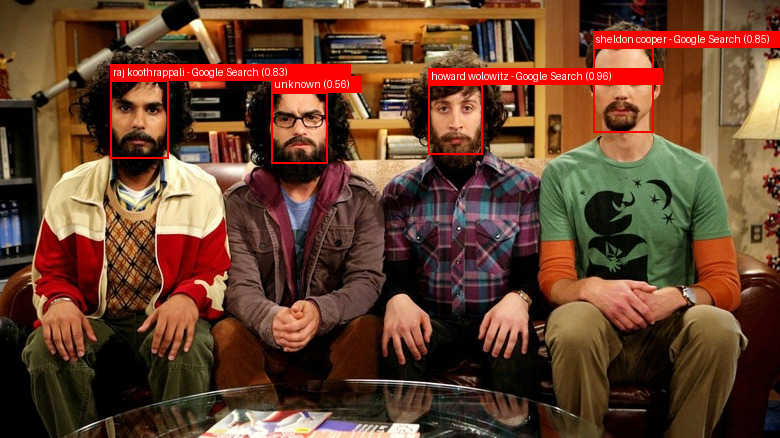

In [29]:
# test_img = '/content/drive/MyDrive/test_images/test1.jpg'  # ajuste
# test_img = '/content/theo.jpeg'  # ajuste
# test_img = '/content/familia.jpeg'  # ajuste
# test_img = '/content/bigbang.jpg'  # ajuste
test_img = '/content/mansbibgbang.jpg'  # ajuste
result_img = recognize_image(test_img, conf_threshold=0.6)
display(result_img)
